In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, LSTM, Bidirectional, Reshape, Attention, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
import random
import zipfile
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras import regularizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [23]:
with zipfile.ZipFile('/content/drive/MyDrive/Speech_Emotion_Recogntion/audio_src/combined_dataset_spectrograms_undersampled.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

print(f"Fichiers extraits dans")

Fichiers extraits dans


In [24]:
spectrograms_dir = '/content/combined_dataset_spectrograms_undersampled'
metrics_dir = '/content/drive/MyDrive/Speech_Emotion_Recogntion/metrics'

In [25]:
images = []
labels = []

fraction = 0.7

emotion_to_index = {
    "angry": 0,
    "happy": 1,
    "sad": 2,
    "neutral": 3,
    "fearful": 4,
    "disgust": 5,
    "surprise": 6,
}

all_files = [file for file in os.listdir(spectrograms_dir) if file.endswith(".png")]
# selected_files = random.sample(all_files, int(len(all_files) * fraction))

for file_name in all_files:
    file_path = os.path.join(spectrograms_dir, file_name)

    img = Image.open(file_path).convert("RGB")
    img = img.resize((128, 128))
    img_array = np.array(img)

    images.append(img_array)

    emotion = file_name.split("_")[1]
    label = emotion_to_index.get(emotion, -1)
    if label == -1:
        raise ValueError(f"Émotion inconnue dans le fichier : {file_name}")

    labels.append(label)

images = np.array(images)
labels = np.array(labels)

# Normalize
images = images / 255.0

# One-hot
num_classes = len(emotion_to_index)
labels_one_hot = to_categorical(labels, num_classes=num_classes)

X_train, X_temp, y_train, y_temp = train_test_split(images, labels_one_hot, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Ensemble d'entraînement : {X_train.shape}, {y_train.shape}")
print(f"Ensemble de validation : {X_val.shape}, {y_val.shape}")
print(f"Ensemble de test : {X_test.shape}, {y_test.shape}")

Ensemble d'entraînement : (7111, 128, 128, 3), (7111, 7)
Ensemble de validation : (1524, 128, 128, 3), (1524, 7)
Ensemble de test : (1524, 128, 128, 3), (1524, 7)


In [26]:
def create_cnn_blstm_with_attention_model(num_classes):
    inputs = Input(shape=(128, 128, 3))

    # CNN layers with L2 regularization and dropout
    x = Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01))(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)  # Dropout after CNN layers

    x = Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    # Flatten and dense layer
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)

    # Reshape for BLSTM
    x = Reshape((4, 32))(x)

    # BLSTM layers with dropout
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = Dropout(0.3)(x)

    # Attention mechanism
    query = Dense(64, activation='relu')(x)
    value = Dense(64, activation='relu')(x)
    attention_output = layers.Attention()([query, value])

    # Fully connected layers
    x = Flatten()(attention_output)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

model = create_cnn_blstm_with_attention_model(num_classes)

model.compile(optimizer='adam',  # You can choose other optimizers like 'sgd', 'rmsprop', etc.
              loss='categorical_crossentropy',  # Use 'sparse_categorical_crossentropy' if your labels are not one-hot encoded
              metrics=['accuracy'])

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 126, 126, 32)   │            896 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_9           │ (None, 63, 63, 32)     │              0 │ conv2d_9[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 63, 63, 32)     │              0 │ max_pooling2d_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 61, 61, 64)     │         18,496 │ dropout_11[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_10          │ (None, 30, 30, 64)     │              0 │ conv2d_10[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_12 (Dropout)      │ (None, 30, 30, 64)     │              0 │ max_pooling2d_10[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 28, 28, 64)     │         36,928 │ dropout_12[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_11          │ (None, 14, 14, 64)     │              0 │ conv2d_11[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_13 (Dropout)      │ (None, 14, 14, 64)     │              0 │ max_pooling2d_11[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_6 (Flatten)       │ (None, 12544)          │              0 │ dropout_13[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_15 (Dense)          │ (None, 128)            │      1,605,760 │ flatten_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_3 (Reshape)       │ (None, 4, 32)          │              0 │ dense_15[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_3           │ (None, 4, 128)         │         49,664 │ reshape_3[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_14 (Dropout)      │ (None, 4, 128)         │              0 │ bidirectional_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_16 (Dense)          │ (None, 4, 64)          │          8,256 │ dropout_14[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_17 (Dense)          │ (None, 4, 64)          │          8,256 │ dropout_14[0][0]       │
├──────────────────────

 Total params: 1,762,055 (6.72 MB)

 Trainable params: 1,762,055 (6.72 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Training the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, lr_scheduler]
)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Loss on the test set : {test_loss}")
print(f"Accuracy on the test set : {test_accuracy}")

Epoch 1/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.1527 - loss: 2.2880 - val_accuracy: 0.2841 - val_loss: 1.8307 - learning_rate: 0.0010
Epoch 2/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.2570 - loss: 1.7897 - val_accuracy: 0.3136 - val_loss: 1.6669 - learning_rate: 0.0010
Epoch 3/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.2982 - loss: 1.6993 - val_accuracy: 0.3642 - val_loss: 1.5587 - learning_rate: 0.0010
Epoch 4/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.3486 - loss: 1.6033 - val_accuracy: 0.4055 - val_loss: 1.4980 - learning_rate: 0.0010
Epoch 5/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.3934 - loss: 1.5281 - val_accuracy: 0.4488 - val_loss: 1.4486 - learning_rate: 0.0010
Epoch 6/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.4171 - loss: 1.4807 - val_accuracy: 0.4783 - val_loss: 1.3798 - learning_rate: 0.0010
Epoch 7/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.4559 - loss: 1

In [28]:
model_name = "CNN_BLSTM_with_attention_V2_undersampled_dataset"
model_metrics_dir = os.path.join(metrics_dir, model_name)
os.makedirs(model_metrics_dir, exist_ok=True)

In [29]:
plt.figure(figsize=(6, 5))

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss Evolution")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig(os.path.join(model_metrics_dir, "loss_curve.png"))
plt.close()

plt.figure(figsize=(6, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy Evolution")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(os.path.join(model_metrics_dir, "accuracy_curve.png"))
plt.close()

In [30]:
# Prédictions sur les données de test
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convertir les probabilités en classes
y_true = np.argmax(y_test, axis=1)  # Convertir les labels one-hot en indices de classes

# Générer la matrice de confusion
conf_matrix = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=emotion_to_index.keys())

# Afficher et sauvegarder la matrice de confusion
plt.figure(figsize=(8, 8))
disp.plot(cmap='Blues', values_format='d', ax=plt.gca())  # Utiliser les valeurs entières pour la matrice
plt.title("Confusion Matrix")
plt.savefig(os.path.join(model_metrics_dir, "confusion_matrix.png"))
plt.close()


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


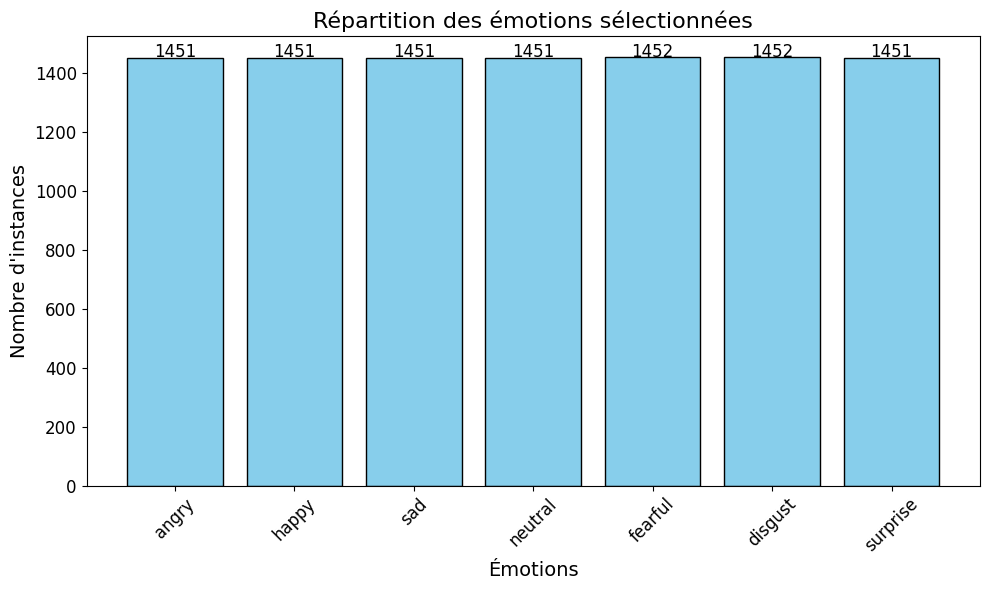

In [31]:
import matplotlib.pyplot as plt
import numpy as np

emotion_counts = {emotion: 0 for emotion in emotion_to_index.keys()}
for label in labels:
    emotion_name = list(emotion_to_index.keys())[list(emotion_to_index.values()).index(label)]
    emotion_counts[emotion_name] += 1

emotions = list(emotion_counts.keys())
counts = list(emotion_counts.values())

plt.figure(figsize=(10, 6))
plt.bar(emotions, counts, color='skyblue', edgecolor='black')
plt.title("Répartition des émotions sélectionnées", fontsize=16)
plt.xlabel("Émotions", fontsize=14)
plt.ylabel("Nombre d'instances", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

for i, count in enumerate(counts):
    plt.text(i, count + 0.5, str(count), ha='center', fontsize=12)

plt.tight_layout()
plt.show()
